In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import Input , Conv2D, MaxPooling2D, Dropout, Dense, Flatten , MaxPool2D
from keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import random

In [7]:
random.seed(1441)

In [8]:
train_data_dir = 'data/'
img_width, img_height = 224, 224
batch_size = 32
epochs = 100
num_classes = 5

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [10]:
base_model = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224,224, 3)))

In [11]:
base_model.trainable = False

In [12]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [13]:
loss = CategoricalCrossentropy(name='loss')
optimizer = Adam(learning_rate=0.0001 , name='optimizer')

In [14]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          589856    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                        

In [16]:
checkpoint_filepath = 'model.h5'
mc = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
)
rlorp = ReduceLROnPlateau(
    min_lr=0.00001,
    monitor='val_loss',
    patience=5,
    factor=0.5
)

In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[mc , rlorp , es]
)

Epoch 1/100
91/91 [==============================] - 88s 871ms/step - loss: 1.2978 - accuracy: 0.4860 - val_loss: 1.2401 - val_accuracy: 0.6435 - lr: 1.0000e-04
Epoch 2/100
91/91 [==============================] - 43s 466ms/step - loss: 1.1969 - accuracy: 0.5140 - val_loss: 1.2528 - val_accuracy: 0.4219 - lr: 1.0000e-04
Epoch 3/100
91/91 [==============================] - 43s 470ms/step - loss: 1.1102 - accuracy: 0.5974 - val_loss: 1.0644 - val_accuracy: 0.6051 - lr: 1.0000e-04
Epoch 4/100
91/91 [==============================] - 43s 471ms/step - loss: 1.0306 - accuracy: 0.6513 - val_loss: 0.9934 - val_accuracy: 0.7031 - lr: 1.0000e-04
Epoch 5/100
91/91 [==============================] - 45s 491ms/step - loss: 0.9674 - accuracy: 0.6792 - val_loss: 0.9694 - val_accuracy: 0.6321 - lr: 1.0000e-04
Epoch 6/100
91/91 [==============================] - 44s 478ms/step - loss: 0.9295 - accuracy: 0.6875 - val_loss: 0.9214 - val_accuracy: 0.7017 - lr: 1.0000e-04
Epoch 7/100
91/91 [===============

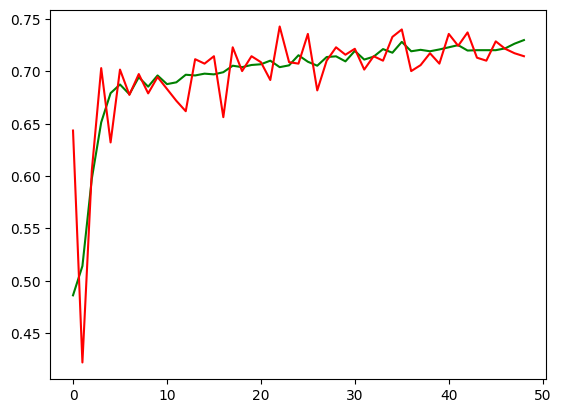

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'] , color='green')
plt.plot(history.history['val_accuracy'] , color='red')
plt.show()

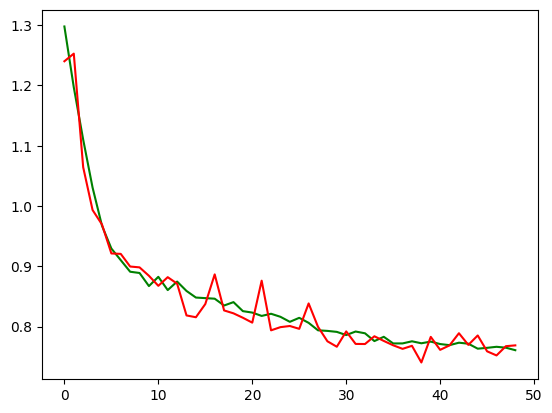

In [19]:
plt.plot(history.history['loss'] , color='green')
plt.plot(history.history['val_loss'] , color='red')
plt.show()

In [20]:
from pickle import dump
with open('classes.h5' , 'wb') as f:
    dump(train_generator.class_indices , f)